In [13]:
from scipy.special import kl_div,rel_entr
import numpy as np
from matplotlib import pyplot as plt
import quantum_classical_LHCdata as qc

import tensorflow as tf
from matplotlib import pyplot
from qibo import gates, hamiltonians, models, set_backend, set_threads
from matplotlib import cm
from matplotlib import pyplot as plt, colors
from matplotlib.offsetbox import AnchoredText
import plots_LHC as plhc

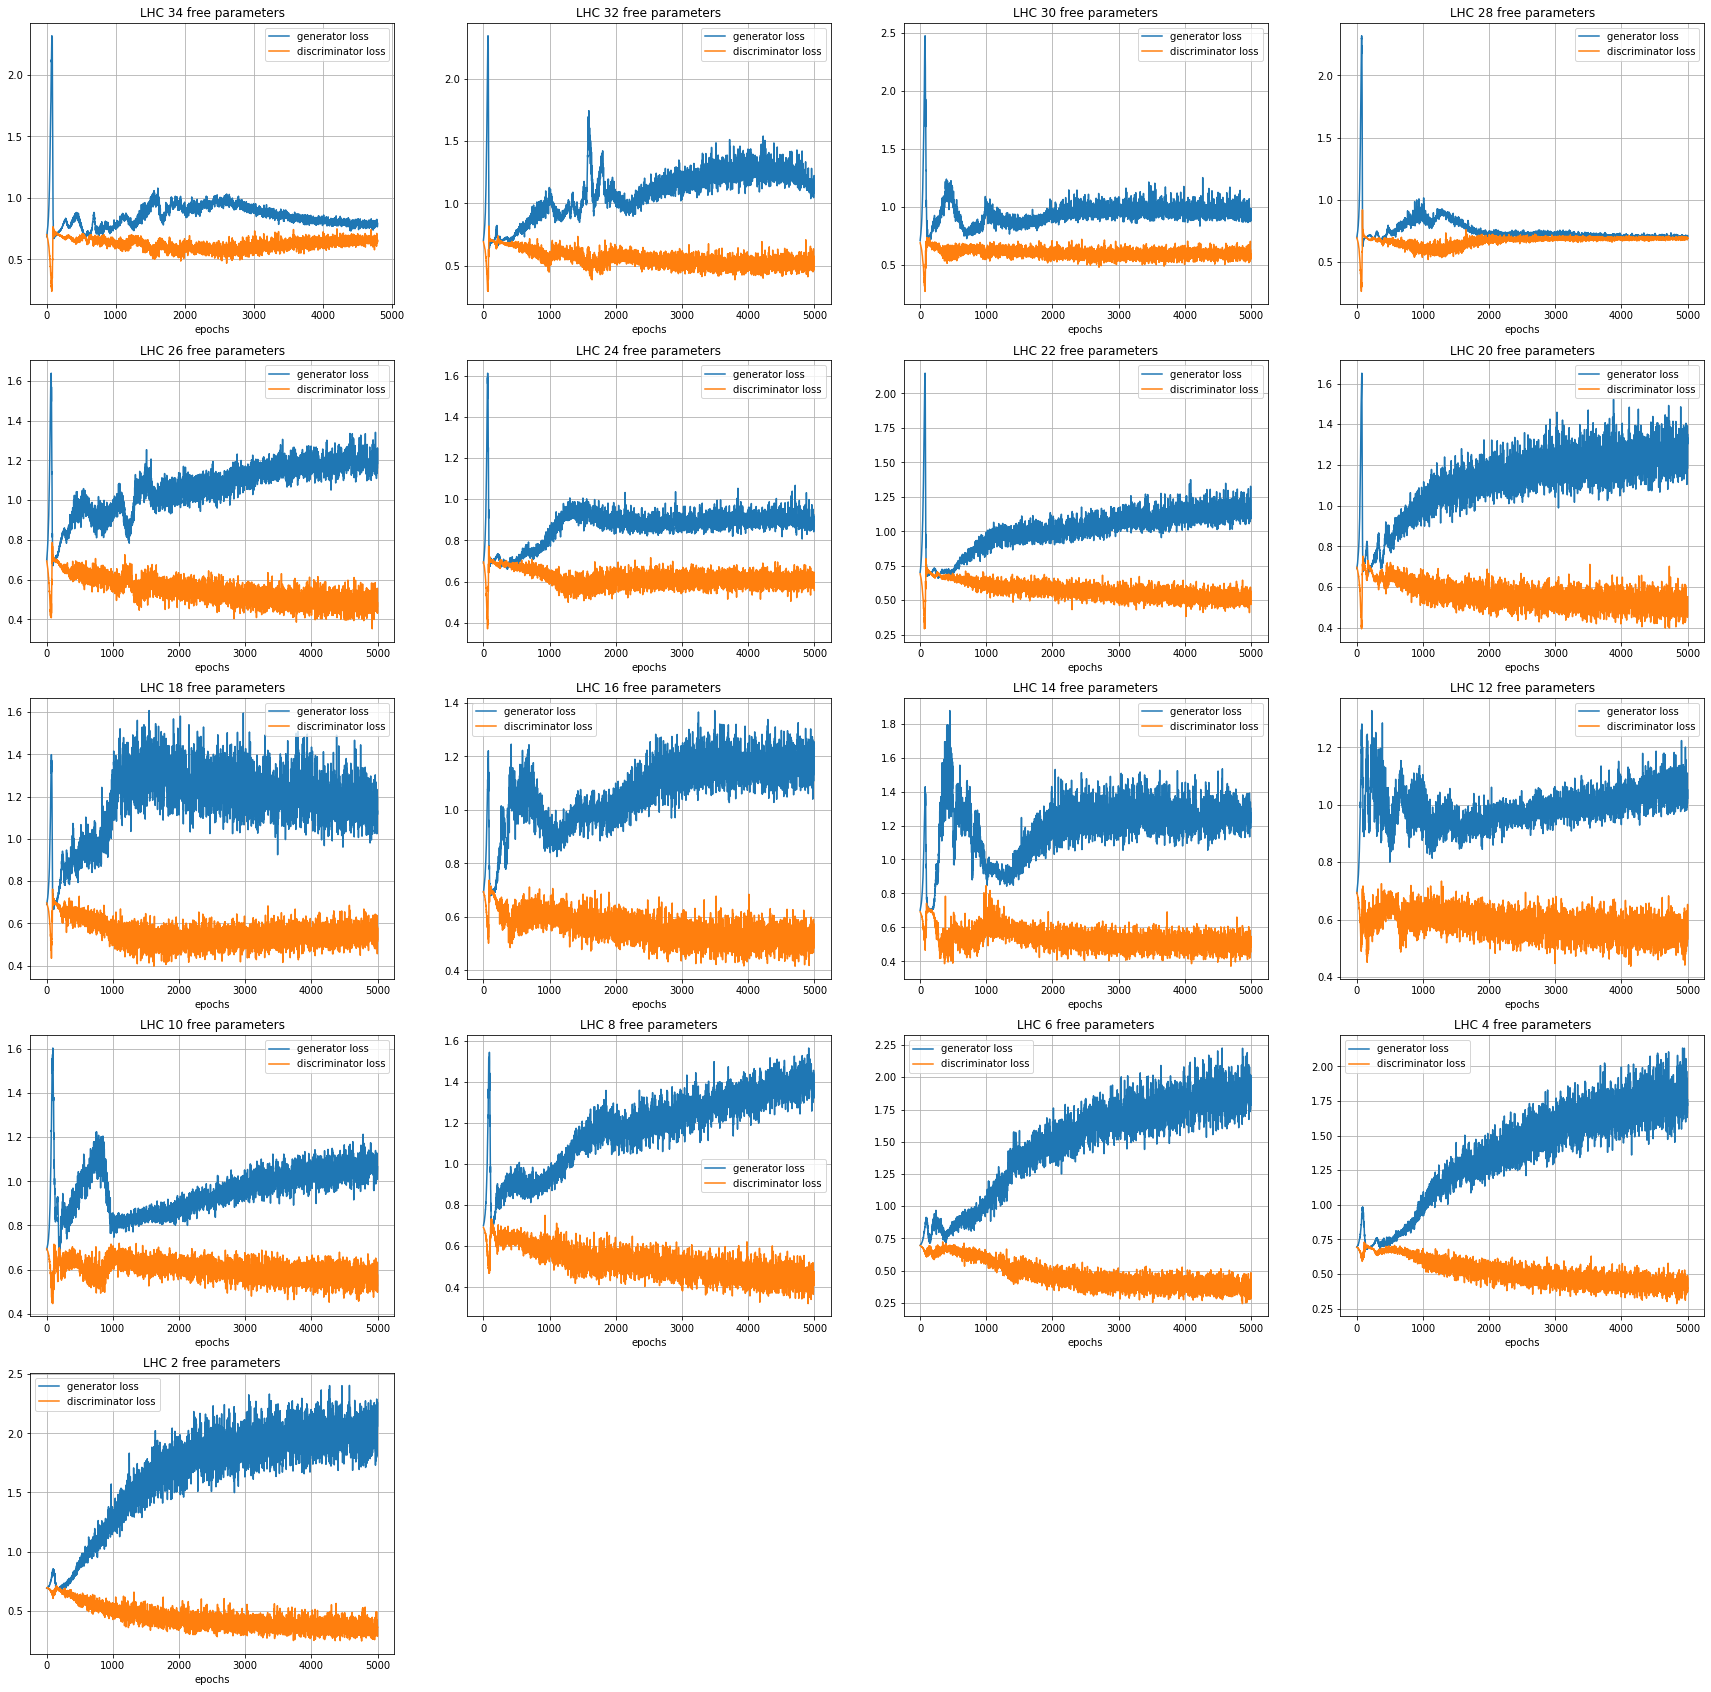

In [8]:
n_layers=128
fixed_params=range(0,34,2)
pyplot.figure(figsize=(30,30))
rows=5
cols=4


for i, val in enumerate(fixed_params):
    
    pyplot.subplot(rows,cols,i+1)
    
    d_loss = np.loadtxt(f"dloss_transfer_learning_LHCdata_3_3_2_10000_128_0.1_{val}", delimiter=' ')
    g_loss= np.loadtxt(f"gloss_transfer_learning_LHCdata_3_3_2_10000_128_0.1_{val}", delimiter=' ')
   
    pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), g_loss, label='generator loss')
    pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), d_loss, label='discriminator loss')
    pyplot.title(f'LHC {34-val} free parameters')
    pyplot.xlabel('epochs')
    pyplot.legend()
    pyplot.grid()

pyplot.show()

In [19]:
# define hamiltonian to generate fake samples
latent_dim=3
samples=100
layers=2
training_samples=10000
n_epochs=30000
batch_samples=128
lr=0.1
    
    
def hamiltonian1():
    id = [[1, 0], [0, 1]]
    m0 = hamiltonians.Z(1).matrix
    m0 = np.kron(id, np.kron(id, m0))
    ham = hamiltonians.Hamiltonian(3, m0)
    return ham
    
def hamiltonian2():
    id = [[1, 0], [0, 1]]
    m0 = hamiltonians.Z(1).matrix
    m0 = np.kron(id, np.kron(m0, id))
    ham = hamiltonians.Hamiltonian(3, m0)
    return ham
    
def hamiltonian3():
    id = [[1, 0], [0, 1]]
    m0 = hamiltonians.Z(1).matrix
    m0 = np.kron(m0, np.kron(id, id))
    ham = hamiltonians.Hamiltonian(3, m0)
    return ham
    
# number of qubits generator
nqubits = 3
# create hamiltonians
hamiltonian1 = hamiltonian1()
hamiltonian2 = hamiltonian2()
hamiltonian3 = hamiltonian3()
# create quantum generator
circuit = models.Circuit(nqubits)
for l in range(layers):
    for q in range(nqubits):
        circuit.add(gates.RY(q, 0))
        circuit.add(gates.RZ(q, 0))
    if l==1 or l==5 or l==9 or l==13 or l==17:
        circuit.add(gates.CRY(0, 1, 0))
        circuit.add(gates.CRY(0, 2, 0))
    if l==3 or l==7 or l==11 or l==15 or l==19:
        circuit.add(gates.CRY(1, 2, 0))
        circuit.add(gates.CRY(2, 0, 0))
for q in range(nqubits):
    circuit.add(gates.RY(q, 0))
    
nqubits = 3
    
for i, val in enumerate(fixed_params):
        
       
    params = np.loadtxt(f"PARAMS_transfer_learning_LHCdata_3_3_2_10000_128_0.1_{val}")

        
    print('generating real samples')
    x_real = plhc.load_events('data/ppttbar_10k_events.lhe')
    x_real1 = []
    x_real2 = []
    x_real3 = []
    for i in range(samples):
        x_real1.append(x_real[i][0])
        x_real2.append(x_real[i][1])
        x_real3.append(x_real[i][2])
            
    print('generating fake samples')   
    print( qc.generate_fake_samples(circuit, params,int( 3), int(100), nqubits, layers, hamiltonian1, hamiltonian2, hamiltonian3,val)
)
    x_fake, _ = qc.generate_fake_samples(circuit, params, latent_dim, samples, nqubits, layers, hamiltonian1, hamiltonian2, hamiltonian3,val)
    init = readInit('data/ppttbar_10k_events.lhe')
    evs = list(readEvent(init))    
    invar = np.zeros((len(evs),3))
    for ev in range(len(evs)):
            invar[ev, 0] = GetEnergySquared(evs[ev])
            invar[ev, 1] = GetMandelT(evs[ev])
            invar[ev, 2] = GetRapidity(init, evs[ev])         
    pt = PowerTransformer()
    print(pt.fit(invar[:10000, :]))
    print(pt.lambdas_)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    print(scaler.fit(pt.transform(invar[:10000, :])))

    x_fake = pt.inverse_transform(scaler.inverse_transform(x_fake))
    x_fake1 = []
    x_fake2 = []
    x_fake3 = []
    for i in range(samples):
        x_fake1.append(x_fake[i][0])
        x_fake2.append(x_fake[i][1])
        x_fake3.append(x_fake[i][2])

generating real samples
generating fake samples


TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
print('1D distributions')
    real, _ = np.array(np.histogram(x_real1, np.logspace(np.log10(min(x_real1)),np.log10(max(x_real1)),bins)))/samples
    fake, _ = np.array(np.histogram(x_fake1, np.logspace(np.log10(min(x_real1)),np.log10(max(x_real1)),bins)))/samples
    for i in range(len(real)):
        if real[i] == 0:
            real[i] = 1e-100        
        if fake[i] == 0:
            fake[i] = 1e-100
    kl_divergence = np.around(entropy(real, fake), 3)
    
    fig = plt.figure(figsize=[10.5/1.5, 7.5/1.5])
    plt.ylabel('Samples', fontsize=17)
    plt.xlabel('', fontsize=17)
    plt.hist(x_real1, np.logspace(np.log10(min(x_real1)),np.log10(max(x_real1)),bins), histtype='step', color='red', label='real', alpha=0.5)
    plt.hist(x_fake1, np.logspace(np.log10(min(x_real1)),np.log10(max(x_real1)),bins), histtype='step', color='blue', label='fake', alpha=0.5)
    plt.rcParams["axes.linewidth"]  = 1.25
    plt.legend(loc='best')
    plt.xscale('log')
    plt.text(0.5e6, max(fake.flatten())*samples, 'KL divergence = '+str(kl_divergence), bbox=dict(fill=False, edgecolor='black', linewidth=2))
    plt.show()
    fig.savefig(f"s-distribution_{samples}_{bins}_{nqubits}_{latent_dim}_{layers}_{training_samples}_{batch_samples}_{lr}.pdf", bbox_inches='tight')
    
    x_real2 = -1*np.array(x_real2)
    x_fake2 = -1*np.array(x_fake2)    
    real, _ = np.array(np.histogram(-1*x_real2, -1*np.logspace(np.log10(max(x_real2)),np.log10(min(x_real2)),bins)))/samples
    fake, _ = np.array(np.histogram(-1*x_fake2, -1*np.logspace(np.log10(max(x_real2)),np.log10(min(x_real2)),bins)))/samples
    for i in range(len(real)):
        if real[i] == 0:
            real[i] = 1e-100        
        if fake[i] == 0:
            fake[i] = 1e-100
    kl_divergence = np.around(entropy(real, fake), 3)
    
    fig = plt.figure(figsize=[10.5/1.5, 7.5/1.5])
    plt.ylabel('Samples', fontsize=17)
    plt.xlabel('', fontsize=17)
    plt.hist(-1*x_real2, -1*np.logspace(np.log10(max(x_real2)),np.log10(min(x_real2)),bins), histtype='step', color='red', label='real', alpha=0.5)
    plt.hist(-1*x_fake2, -1*np.logspace(np.log10(max(x_real2)),np.log10(min(x_real2)),bins), histtype='step', color='blue', label='fake', alpha=0.5)
    plt.rcParams["axes.linewidth"]  = 1.25
    plt.legend(loc=2)
    plt.xscale('symlog')
    plt.text(-0.5e6, max(fake.flatten())*samples, 'KL divergence = '+str(kl_divergence), bbox=dict(fill=False, edgecolor='black', linewidth=2))
    plt.show()
    fig.savefig(f"t-distribution_{samples}_{bins}_{nqubits}_{latent_dim}_{layers}_{training_samples}_{batch_samples}_{lr}.pdf", bbox_inches='tight')
        
    real, _ = np.array(np.histogram(x_real3, np.linspace(min(x_real3),max(x_real3),bins)))/samples
    fake, _ = np.array(np.histogram(x_fake3, np.linspace(min(x_real3),max(x_real3),bins)))/samples
    for i in range(len(real)):
        if real[i] == 0:
            real[i] = 1e-100        
        if fake[i] == 0:
            fake[i] = 1e-100
    kl_divergence = np.around(entropy(real, fake), 3)
    
    fig = plt.figure(figsize=[10.5/1.5, 7.5/1.5])
    plt.ylabel('Samples', fontsize=17)
    plt.xlabel('', fontsize=17)
    plt.hist(x_real3, np.linspace(min(x_real3),max(x_real3),bins), histtype='step', color='red', label='real', alpha=0.5)
    plt.hist(x_fake3, np.linspace(min(x_real3),max(x_real3),bins), histtype='step', color='blue', label='fake', alpha=0.5)
    plt.rcParams["axes.linewidth"]  = 1.25
    plt.legend()
    plt.text(-2, max(fake.flatten())*samples, 'KL divergence = '+str(kl_divergence), bbox=dict(fill=False, edgecolor='black', linewidth=2))
    plt.show()
    fig.savefig(f"y-distribution_{samples}_{bins}_{nqubits}_{latent_dim}_{layers}_{training_samples}_{batch_samples}_{lr}.pdf", bbox_inches='tight')
    
    if plot_real==True:
        print('Real 2D distributions')
        fig = plt.figure(figsize=[10.5/1.5, 7.5/1.5])
        plt.ylabel('', fontsize=17)
        plt.xlabel('', fontsize=17)
        plt.hist2d(x_real1, -1*x_real2, [np.logspace(np.log10(min(x_real1)),np.log10(max(x_real1)),bins),-1*np.logspace(np.log10(max(x_real2)),np.log10(min(x_real2)),bins)], color='red', label='real', alpha=1.0, linewidths=0)
        plt.colorbar()
        plt.rcParams["axes.linewidth"]  = 1.25
        plt.xscale('log')
        plt.yscale('symlog')
        plt.show()
        fig.savefig(f"s-t_REAL_{samples}_{bins}.pdf", bbox_inches='tight')
        
        fig = plt.figure(figsize=[10.5/1.5, 7.5/1.5])
        plt.ylabel('', fontsize=17)
        plt.xlabel('', fontsize=17)
        plt.hist2d(-1*x_real2, x_real3, [-1*np.logspace(np.log10(max(x_real2)),np.log10(min(x_real2)),bins),np.linspace(min(x_real3),max(x_real3),bins)], color='red', label='real', alpha=1.0, linewidths=0)
        plt.colorbar()
        plt.rcParams["axes.linewidth"]  = 1.25
        plt.xscale('symlog')
        plt.show()
        fig.savefig(f"t-y_REAL_{samples}_{bins}.pdf", bbox_inches='tight')
        
        fig = plt.figure(figsize=[10.5/1.5, 7.5/1.5])
        plt.ylabel('', fontsize=17)
        plt.xlabel('', fontsize=17)
        plt.hist2d(x_real3, x_real1, [np.linspace(min(x_real3),max(x_real3),bins),np.logspace(np.log10(min(x_real1)),np.log10(max(x_real1)),bins)], color='red', label='real', alpha=1.0, linewidths=0)
        plt.colorbar()
        plt.rcParams["axes.linewidth"]  = 1.25
        plt.yscale('log')
        plt.show()
        fig.savefig(f"y-s_REAL_{samples}_{bins}.pdf", bbox_inches='tight')
    
    print('Fake 2D distributions')
    H, xedges, yedges = np.histogram2d(x_real1, -1*x_real2, [np.logspace(np.log10(min(x_real1)),np.log10(max(x_real1)),bins),-1*np.logspace(np.log10(max(x_real2)),np.log10(min(x_real2)),bins)])    
    fig = plt.figure(figsize=[10.5/1.5, 7.5/1.5])
    plt.ylabel('', fontsize=17)
    plt.xlabel('', fontsize=17)
    plt.hist2d(x_fake1, -1*x_fake2, [np.logspace(np.log10(min(x_real1)),np.log10(max(x_real1)),bins),-1*np.logspace(np.log10(max(x_real2)),np.log10(min(x_real2)),bins)], color='red', vmax=max(H.flatten()), label='real', alpha=1.0, linewidths=0)
    plt.colorbar()
    plt.rcParams["axes.linewidth"]  = 1.25
    plt.xscale('log')
    plt.yscale('symlog')
    plt.show()
    fig.savefig(f"s-t_FAKE_{samples}_{bins}_{nqubits}_{latent_dim}_{layers}_{training_samples}_{batch_samples}_{lr}.pdf", bbox_inches='tight')
    
    H, xedges, yedges = np.histogram2d(-1*x_real2, x_real3, [-1*np.logspace(np.log10(max(x_real2)),np.log10(min(x_real2)),bins),np.linspace(min(x_real3),max(x_real3),bins)])    
    fig = plt.figure(figsize=[10.5/1.5, 7.5/1.5])
    plt.ylabel('', fontsize=17)
    plt.xlabel('', fontsize=17)
    plt.hist2d(-1*x_fake2, x_fake3, [-1*np.logspace(np.log10(max(x_real2)),np.log10(min(x_real2)),bins),np.linspace(min(x_real3),max(x_real3),bins)], color='red', vmax=max(H.flatten()), label='real', alpha=1.0, linewidths=0)
    plt.colorbar()
    plt.rcParams["axes.linewidth"]  = 1.25
    plt.xscale('symlog')
    plt.show()
    fig.savefig(f"t-y_FAKE_{samples}_{bins}_{nqubits}_{latent_dim}_{layers}_{training_samples}_{batch_samples}_{lr}.pdf", bbox_inches='tight')
    
    H, xedges, yedges = np.histogram2d(x_real3, x_real1, [np.linspace(min(x_real3),max(x_real3),bins),np.logspace(np.log10(min(x_real1)),np.log10(max(x_real1)),bins)])    
    fig = plt.figure(figsize=[10.5/1.5, 7.5/1.5])
    plt.ylabel('', fontsize=17)
    plt.xlabel('', fontsize=17)
    plt.hist2d(x_fake3, x_fake1, [np.linspace(min(x_real3),max(x_real3),bins),np.logspace(np.log10(min(x_real1)),np.log10(max(x_real1)),bins)], color='red', vmax=max(H.flatten()), label='real', alpha=1.0, linewidths=0)
    plt.colorbar()
    plt.rcParams["axes.linewidth"]  = 1.25
    plt.yscale('log')
    plt.show()
    fig.savefig(f"y-s_FAKE_{samples}_{bins}_{nqubits}_{latent_dim}_{layers}_{training_samples}_{batch_samples}_{lr}.pdf", bbox_inches='tight')
